In [1]:
%load_ext autoreload
%autoreload 2

from constructions1D import *
from constructions2D import *
from geometricMultiGrid import *
from plt_utils import *

from scipy.sparse.linalg import spsolve,gmres, LinearOperator
from scipy.sparse import eye
from scipy.linalg import norm
import numpy as np

from functools import partial

import matplotlib.pyplot as plt
from ipywidgets import interact,widgets 

plt.rc('axes', grid=True)
plt.rc('legend', loc='best')
plt.style.use('ggplot')

# 1.2 1D model problem
## (b)

C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


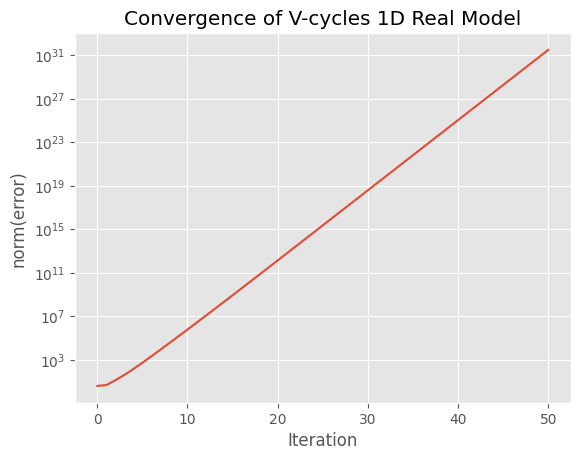

In [2]:
def helmholtz1D_model_1_2b(sigma=-600, omega = 2/3,n=64,recursion_depth=5,iterations =50):
    f = pointsource_half(n)
    u_approx = guessv0(n)
    u_exact = spsolve(helmholtz1D(n,sigma),f)
    errors = [u_exact-u_approx] 
    for _ in range(iterations):
        u_approx = geoVcycle(
            mat = partial(helmholtz1D,sigma=sigma), 
            f= f, 
            u = u_approx, 
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= omega), 
            restrict=simple_restrict, 
            interpolate=simple_interpolate, 
            recursion_depth=recursion_depth)
        errors.append(u_exact-u_approx)
    return errors

n = 64 
sigma = -600 
omega = 2/3 
errors = helmholtz1D_model_1_2b(sigma=sigma,omega=omega,n=n,recursion_depth=20,iterations =50)
norms = np.array([norm(e) for e in errors])
plt.plot(norms)
plt.xlabel("Iteration")
plt.ylabel("norm(error)")
plt.yscale("log")
plt.title("Convergence of V-cycles 1D Real Model")
plt.savefig("./plts/convergence_1Dreal", dpi=300)
plt.show()

## (d)

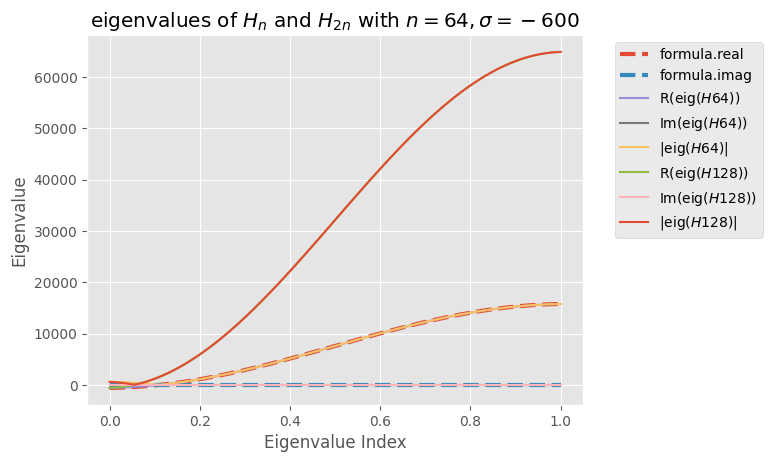

In [3]:
n = 64
sigma = -600
title = rf'eigenvalues of $H_n$ and $H_{{2n}}$ with $n={n},\sigma = {sigma}$'
Hs = [helmholtz1D(n*j, sigma) for j in [1,2]]
labels = [f'$H{j}$' for j in [n,2*n]]
ys = np.array([eigen_helmhotz1D(n,k,sigma) for k in range(1,n)])
xs = np.linspace(0,1,len(ys))
plt.plot(xs,ys.real,label="formula.real",linestyle="--",linewidth=3)
plt.plot(xs,ys.imag,label="formula.imag",linestyle="--",linewidth=3)
plt_eigen(Hs,labels,title)
plt.savefig("./plts/eigenvalues_1Dreal", dpi=300,bbox_inches='tight')
plt.show()


# 1.3
## (b)

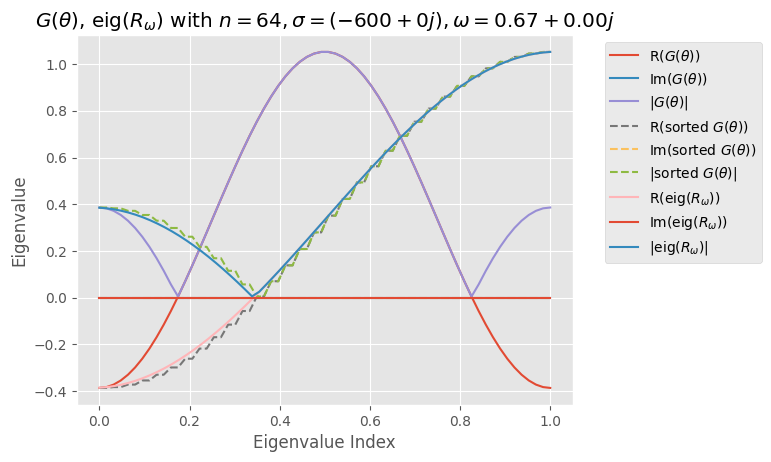

In [4]:
def G(theta,sigma,omega,n):
    return  1-omega+ 2*(omega * n**2)*np.cos(theta)/(2*n**2+sigma)

sigma = complex(-600,0)
omega = complex(2/3,0)
theta = np.linspace(-np.pi, np.pi, n)
Gs = G(theta, sigma, omega, n)
Gs_sorted = np.array(sorted(Gs, key=lambda x: np.abs(
    x)*(0 if x.real == 0 else x.real/np.abs(x.real))))
xs = np.linspace(0, 1, len(Gs))
plt_R_im_abs(xs,Gs,r"$G(\theta)$")
plt_R_im_abs(xs,Gs_sorted,r"sorted $G(\theta)$","--")
title = rf'$G(\theta)$, eig($R_\omega$) with $n={n},\sigma = {sigma}, \omega = {omega:.2f}$'
plt_eigen([Romega(n, sigma,omega)],[r"$R_\omega$"],title)
plt.savefig("./plts/eigenvalues_1DrealG", dpi=300,bbox_inches='tight')
plt.show()


## (d)

In [5]:
G(0,-600,2/3,64)

1.0526870389884089

# 1.4

## (b)

C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Index of maximum value in eggs:  6


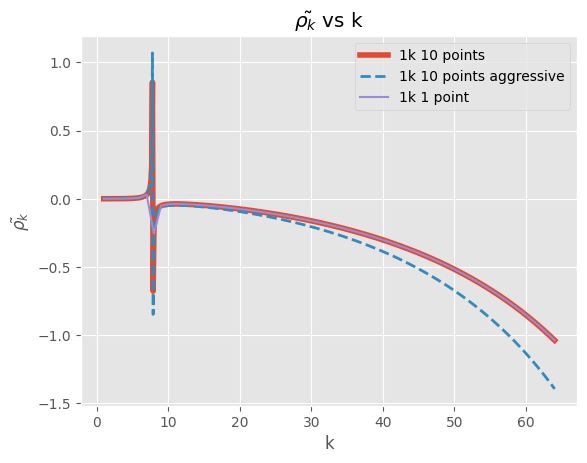

In [6]:
n = 64
sigma = complex(-600,0)
ks = np.linspace(1,n,n*10)
rho_k = [1-eigen_helmhotz1D(2*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
rho_k_aggressive = [1-eigen_helmhotz1D(4*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
plt.plot(ks,rho_k, label= "1k 10 points",linewidth=4)
plt.plot(ks,rho_k_aggressive, label= "1k 10 points aggressive",linestyle="--",linewidth=2)
ks = np.linspace(1,n,n)
rho_k = [1-eigen_helmhotz1D(2*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
plt.plot(ks,rho_k, label="1k 1 point")
plt.legend()
max_index = np.argmax(np.array(rho_k).real)
plt.title(r"$\tilde{\rho_{k}}$ vs k")
print("Index of maximum value in eggs: ", max_index)  
plt.xlabel("k")
plt.ylabel(r"$\tilde{\rho_{k}}$")
plt.savefig("./plts/rho_k_1DrealG", dpi=300,bbox_inches='tight')
plt.show()


# 2.1

## (a)

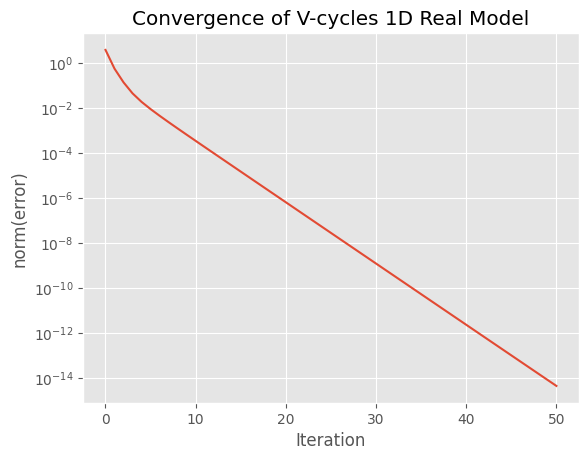

In [7]:
n = 64 
sigma = complex(-600,-300)
omega = 2/3 
errors = helmholtz1D_model_1_2b(sigma=sigma,omega=omega,n=n,recursion_depth=20,iterations =50)
norms = np.array([norm(e) for e in errors])
plt.plot(norms)
plt.xlabel("Iteration")
plt.ylabel("norm(error)")
plt.yscale("log")
plt.title("Convergence of V-cycles 1D Real Model")
plt.savefig("./plts/convergence_1Dcomplex", dpi=300)
plt.show()

## (b)

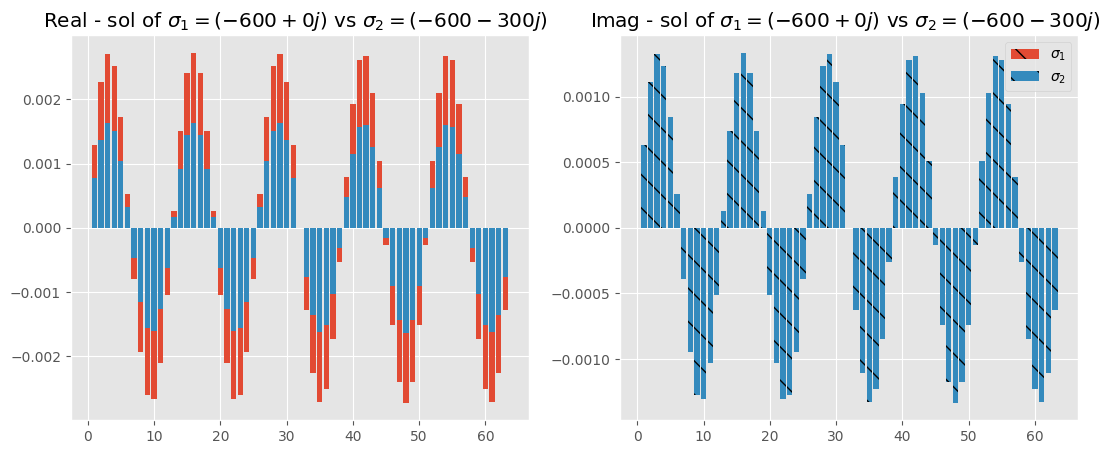

In [8]:
n =64
sigma1 = complex(-600,0)
sigma2 = complex(-600,-300)
# f = pointsource_half(n)
f = wave_basis_1D(n,10)
u_exact1 = spsolve(helmholtz1D(n,sigma1),f)
u_exact2 = spsolve(helmholtz1D(n,sigma2),f)
title = rf"sol of $\sigma_1 = {sigma1}$ vs $\sigma_2 = {sigma2}$  "
plt_vec(u_exact1,label=r"$\sigma_{1}$")
plt_vec(u_exact2,title,reuse=True,label=r"$\sigma_{2}$")
plt.legend()
plt.savefig("./plts/exact_1Dcomplex", dpi=300)
plt.show()

## (c)

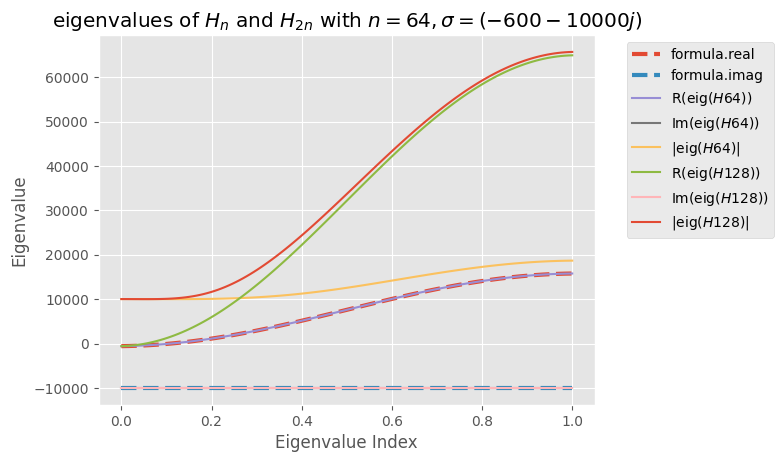

In [9]:
n = 64
sigma = complex(-600,-10000)
title = rf'eigenvalues of $H_n$ and $H_{{2n}}$ with $n={n},\sigma = {sigma}$'
Hs = [helmholtz1D(n*j, sigma) for j in [1,2]]
labels = [f'$H{j}$' for j in [n,2*n]]
ys = np.array([eigen_helmhotz1D(n,k,sigma) for k in range(1,n)])
xs = np.linspace(0,1,len(ys))
plt.plot(xs,ys.real,label="formula.real",linestyle="--",linewidth=3)
plt.plot(xs,ys.imag,label="formula.imag",linestyle="--",linewidth=3)
plt_eigen(Hs,labels,title)
plt.savefig("./plts/eigenvalues_1Dcomplex", dpi=300,bbox_inches='tight')
plt.show()

# 2.2

## (b)

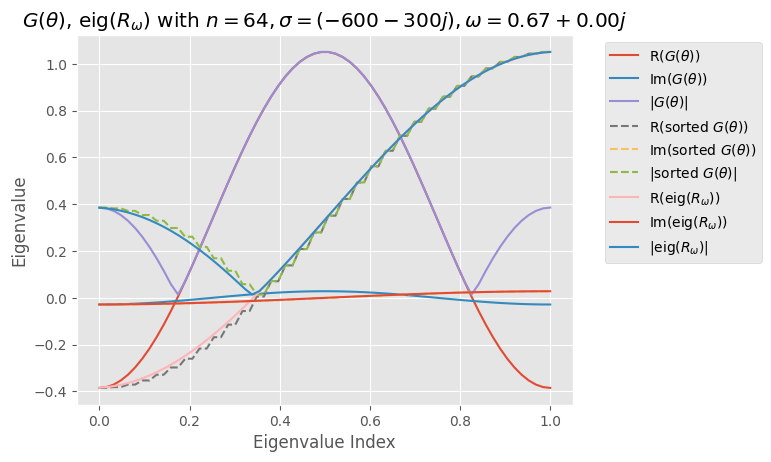

In [10]:
def G(theta,sigma,omega,n):
    return  1-omega+ 2*(omega * n**2)*np.cos(theta)/(2*n**2+sigma)

sigma = complex(-600,-300)
omega = complex(2/3,0)
theta = np.linspace(-np.pi, np.pi, n)
Gs = G(theta, sigma, omega, n)
Gs_sorted = np.array(sorted(Gs, key=lambda x: np.abs(
    x)*(0 if x.real == 0 else x.real/np.abs(x.real))))
xs = np.linspace(0, 1, len(Gs))
plt_R_im_abs(xs,Gs,r"$G(\theta)$")
plt_R_im_abs(xs,Gs_sorted,r"sorted $G(\theta)$","--")
title = rf'$G(\theta)$, eig($R_\omega$) with $n={n},\sigma = {sigma}, \omega = {omega:.2f}$'
plt_eigen([Romega(n, sigma,omega)],[r"$R_\omega$"],title)
plt.savefig("./plts/eigenvalues_1DcomplexG", dpi=300,bbox_inches='tight')
plt.show()

## (c)

Finding 
$$
\mu=\max _{\pi / 2 \leq|\theta| \leq \pi}|G(\theta)| 
.
$$ 
is tedious we use sympy and some simplifications. By squaring our target function 
it becomes differentiable with respect to $\theta$. We first find the local 
critical points and the eliminate the candidates. 

In [11]:
from sympy import symbols, cos, diff, solve, Abs, I,latex, pi,limit,oo
from IPython.display import display, Math

omega, sigma_r, theta, n = symbols('omega sigma_r theta n', real=True)
sigma = sigma_r + I * symbols('sigma_imag', real=True)  # sigma is complex

G = 1 - omega + 2 * cos(theta) * (omega * n**2) / (2 * n**2 + sigma)

modulus_expr = Abs(G)**2
derivative = diff(modulus_expr, theta).simplify()
critical_points = solve(derivative, theta)
critical_points.append(pi/2)
critical_points = [p.simplify() for p in critical_points]
modulus_at_critical_points = [modulus_expr.subs(theta, point).simplify().factor() for point in critical_points]

print(f"----critical points----")
for t, expr in zip(critical_points,modulus_at_critical_points):
    display(Math(f"|G ({latex(t)} )|^2= {latex(expr)}"))

----critical points----


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$0$ is out of range, and everything but the critical point at $\pi$ is smaller then the critical point 
at $\frac{\pi}{2}$. 
Taking the limit for $n\rightarrow \infty$ is a thing.

## (d)


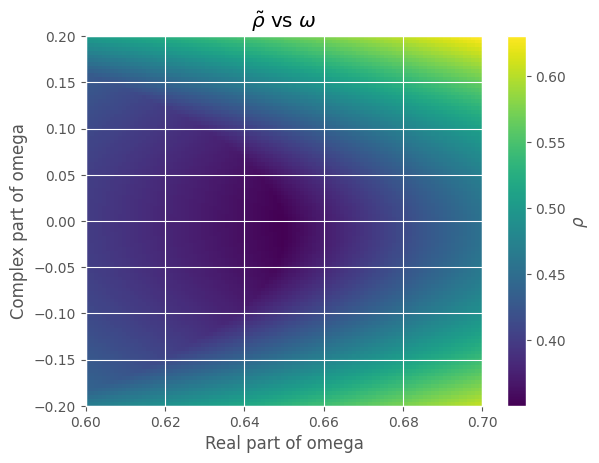

The omega that reaches the minimum is: 0.6494949494949495 + -0.002020202020202033j, rho = 0.3505108723645395


In [12]:
def G(theta, sigma, omega, n):
    return 1 - omega + 2 * (omega * n**2) * np.cos(theta) / (2 * n**2 + sigma)

def max_G(sigma, n, resolution=100):
    omega_real = np.linspace(0.6, 0.7, resolution)
    omega_complex = np.linspace(-0.2, 0.2, resolution)
    max_values = np.zeros((resolution, resolution), dtype=np.float64)

    for i, real_part in enumerate(omega_real):
        for j, complex_part in enumerate(omega_complex):
            omega = complex(real_part, complex_part)
            thetas = np.linspace(np.pi/2, np.pi, 40)
            values = [np.abs(G(theta, sigma, omega, n)) for theta in thetas]
            max_values[j, i] = np.max(values)

    return omega_real, omega_complex, max_values

sigma = complex(-600, -300)
n = 64
omega_real, omega_complex, max_values = max_G(sigma, n)

plt.imshow(max_values, extent=[0.6, 0.7, -0.2, 0.2], origin='lower', cmap='viridis', aspect='auto')
# plt.grid(False)
plt.colorbar().set_label(r'$\rho$')
plt.xlabel('Real part of omega')
plt.ylabel('Complex part of omega')
plt.title(r"$\tilde{\rho}$ vs $\omega$")
plt.savefig("./plts/rho_omega_1Dcomplex", dpi=300,bbox_inches='tight')
plt.show()

min_value = np.min(max_values)
min_indices = np.where(max_values == min_value)
min_omega_real = omega_real[min_indices[1][0]]
min_omega_complex = omega_complex[min_indices[0][0]]

print(f"The omega that reaches the minimum is: {min_omega_real} + {min_omega_complex}j, rho = {min_value}")

# 2.3
## (a)
We use the formula.

C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Index of maximum value in eggs:  6


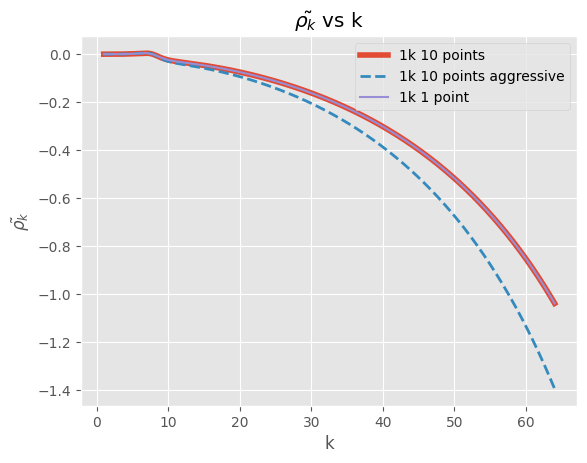

In [13]:
n = 64
sigma = complex(-600,-300)
ks = np.linspace(1,n,n*10)
rho_k = [1-eigen_helmhotz1D(2*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
rho_k_aggressive = [1-eigen_helmhotz1D(4*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
plt.plot(ks,rho_k, label= "1k 10 points",linewidth=4)
plt.plot(ks,rho_k_aggressive, label= "1k 10 points aggressive",linestyle="--",linewidth=2)
ks = np.linspace(1,n,n)
rho_k = [1-eigen_helmhotz1D(2*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
plt.plot(ks,rho_k, label="1k 1 point")
plt.legend()
max_index = np.argmax(np.array(rho_k).real)
plt.title(r"$\tilde{\rho_{k}}$ vs k")
print("Index of maximum value in eggs: ", max_index)  
plt.xlabel("k")
plt.ylabel(r"$\tilde{\rho_{k}}$")
plt.savefig("./plts/rho_k_1DcomplexG", dpi=300,bbox_inches='tight')
plt.show()

# 2.4
## (b)

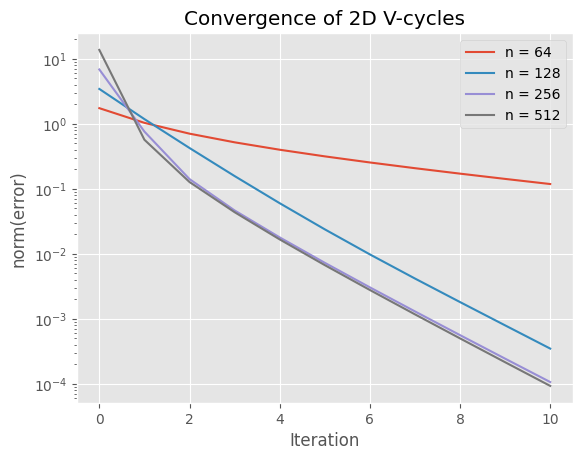

In [14]:
def helmholtz2D_model(sigma=complex(-600,-300), omega = 2/3,n=64,recursion_depth=3,iterations =12,g = pointsource_half2D):
    f = g(n)
    u_approx = np.zeros((n-1)**2) 
    u_exact = spsolve(helmholtz2D(n,sigma),f)
    errors = [u_exact-u_approx] 
    for _ in range(iterations):
        u_approx = geoVcycle(
            mat = (partial(helmholtz2D,sigma=sigma)), 
            f= f, 
            u = u_approx, 
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= omega), 
            restrict=simple_restrict2D, 
            interpolate=simple_interpolate2D, 
            recursion_depth=recursion_depth,
            dimensions =2)
        errors.append(u_exact-u_approx)
    return errors

for n in [64,128,256,512]:
    errors = helmholtz2D_model(n=n,iterations = 10) 
    norms =  [norm(e) for e in errors] 
    plt.plot(norms, label=f"n = {n}")

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("norm(error)")
plt.title("Convergence of 2D V-cycles")
plt.grid(True)
plt.legend()
plt.savefig("./plts/convergence_2Dcomplex", dpi=300,bbox_inches='tight')
plt.show()


# 2.5
## (b)

In [15]:

def simple_interpolate_aggressive(u):
    return simple_interpolate(simple_interpolate(u))

def simple_restrict_aggressive(u):
    return simple_restrict(simple_restrict(u))

def helmholtz1D_model_aggressive(sigma=complex(-600,-300), omega = 2/3,log4n=3,recursion_depth=200,iterations =50):
    n = int(4**log4n)
    f = pointsource_half(n)
    u_approx = guessv0(n)
    u_exact = spsolve(helmholtz1D(n,sigma),f)
    errors = [u_exact-u_approx] 
    for _ in range(iterations):
        u_approx = geoVcycle(
            mat = partial(helmholtz1D,sigma=sigma), 
            f= f, 
            u = u_approx, 
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= omega), 
            restrict=simple_restrict_aggressive, 
            interpolate=simple_interpolate_aggressive, 
            recursion_depth=recursion_depth)
        errors.append(u_exact-u_approx)
    return errors

C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


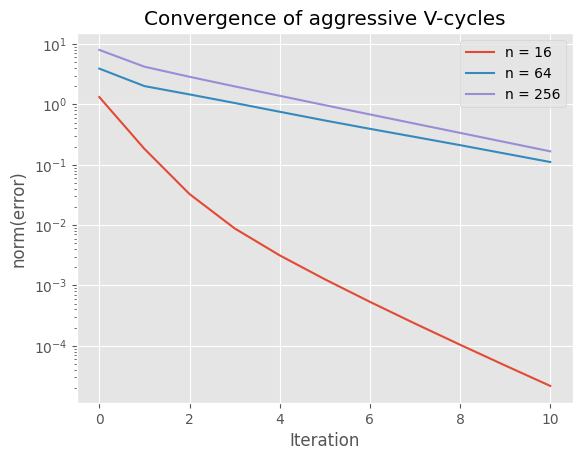

In [16]:
for log4n in range(2,5):
    errors = helmholtz1D_model_aggressive(
        log4n=log4n,
        sigma=complex(-600,-600),
        iterations = 10,
        recursion_depth=log4n-1) 
    norms =  [norm(e) for e in errors] 
    plt.plot(norms, label=f"n = {int(4**log4n)}")

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("norm(error)")
plt.title("Convergence of aggressive V-cycles")
plt.legend()
plt.show()

# 3.1

In [17]:
def GMRES_norms(n,pre_con=None,restart=20,max_iter =1,label="", f= pointsource_half2D,dotted=False):
    if not(pre_con):
        pre_con = eye((n-1)**2)

    pr_norms = []
    def callback(x):
        pr_norms.append(x)

    sol, info = gmres(
        A = helmholtz2D(n,-600), 
        b= f(n),
        M = pre_con, 
        restart = restart,
        maxiter=max_iter,
        callback= callback,
        callback_type ="pr_norm")
    plt.plot(pr_norms,label=label,linestyle = "--" if dotted else "-")
    plt.yscale('log')
    plt.title("GMRES pre, norm residuals")
    plt.xlabel("Iteration")
    plt.ylabel("norm(relative residual)")


def Helmholtz2D_MG_pre_Vcycle(n,sigma,f=pointsource_half2D):
    return LinearOperator(((n-1)**2,(n-1)**2),lambda u: geoVcycle(
            mat = (partial(helmholtz2D,sigma=sigma)), 
            f= f(n), 
            u=u,
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= 2/3), 
            restrict=simple_restrict2D, 
            interpolate=simple_interpolate2D, 
            recursion_depth=100,
            dimensions =2
))

C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_isolve\iterative.py:668: ComplexWarning: Casting complex values to real discards the imaginary part
  work[slice1] = psolve(work[slice2])


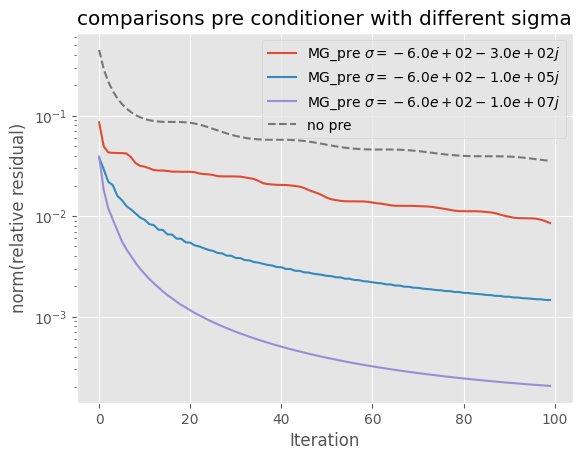

In [18]:
n = 128
rsts = 100
miter = 1
f = pointsource_half2D
sigmas = [complex(-600,x) for x in [-300,-10**5,-10**7]]
for sigma in sigmas:
    GMRES_norms(n,Helmholtz2D_MG_pre_Vcycle(n,sigma,f),rsts,miter,label=rf"MG_pre $\sigma = {sigma:.1e}$",f=f)

GMRES_norms(n,None,rsts,miter,label="no pre",f=f,dotted=True)
plt.title("comparisons pre conditioner with different sigma")
plt.legend()
plt.savefig("./plts/convergence_gmres_pointsource", dpi=300,bbox_inches='tight')
plt.show()

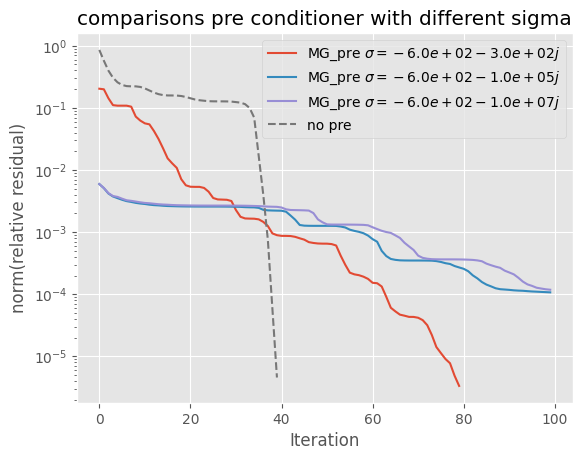

In [19]:
n = 64
rsts = 100
miter = 1
f = lambda n:wave_basis_2Dx(n,2) 
sigmas = [complex(-600,x) for x in [-300,-10**5,-10**7]]
for sigma in sigmas:
    GMRES_norms(n,Helmholtz2D_MG_pre_Vcycle(n,sigma,f),rsts,miter,label=rf"MG_pre $\sigma = {sigma:.1e}$",f=f)

GMRES_norms(n,None,rsts,miter,label="no pre",f=f,dotted=True)
plt.title("comparisons pre conditioner with different sigma")
plt.legend()
plt.savefig("./plts/convergence_gmres_wave_basis", dpi=300,bbox_inches='tight')
plt.show()

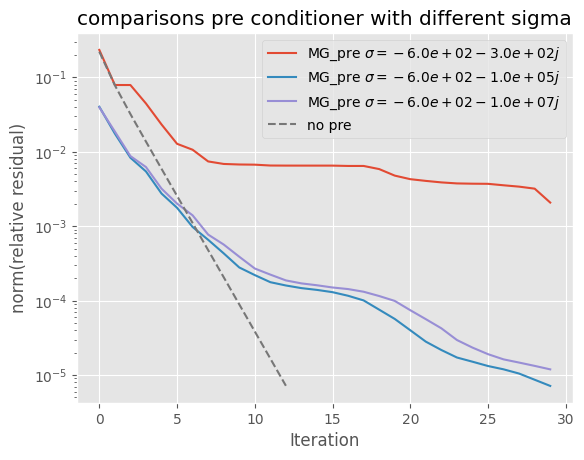

In [20]:
n = 64
rsts = 30
miter = 1
f = lambda n:wave_basis_2Dx(n,20)
sigmas = [complex(-600,x) for x in [-300,-10**5,-10**7]]
for sigma in sigmas:
    GMRES_norms(n,Helmholtz2D_MG_pre_Vcycle(n,sigma,f),rsts,miter,label=rf"MG_pre $\sigma = {sigma:.1e}$",f=f)

GMRES_norms(n,None,rsts,miter,label="no pre",f=f,dotted=True)
plt.title("comparisons pre conditioner with different sigma")
plt.legend()
# plt.savefig("./plts/convergence_gmres_wave_basis30", dpi=300,bbox_inches='tight')
plt.show()